### Does an ensemble approach that combines predictions from Logistic Regression, Random Forest, and XGBoost improve the accuracy and reliability of loan default predictions compared to individual models in the given dataset?

c:\Users\bhart\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


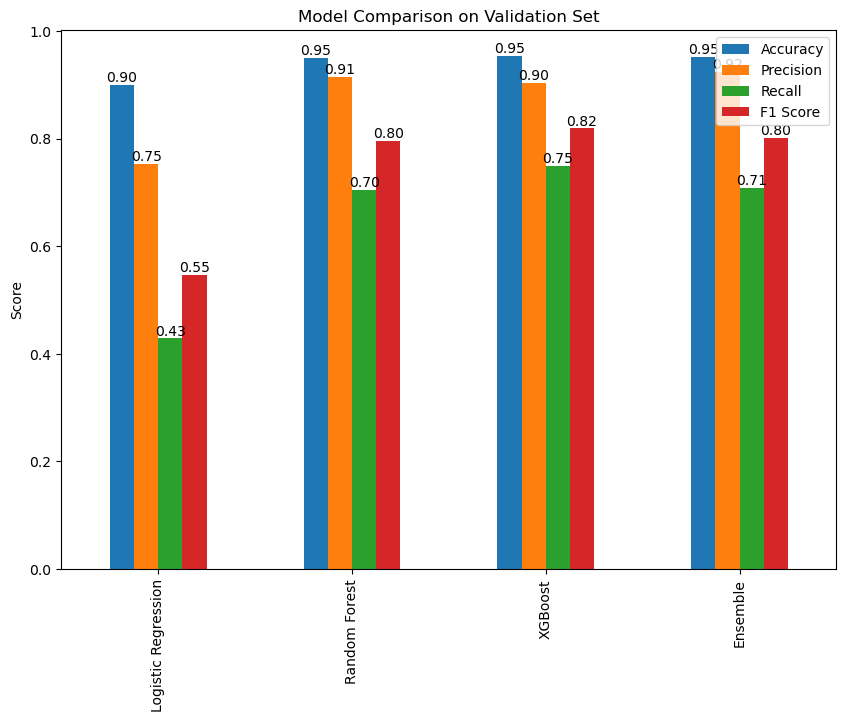

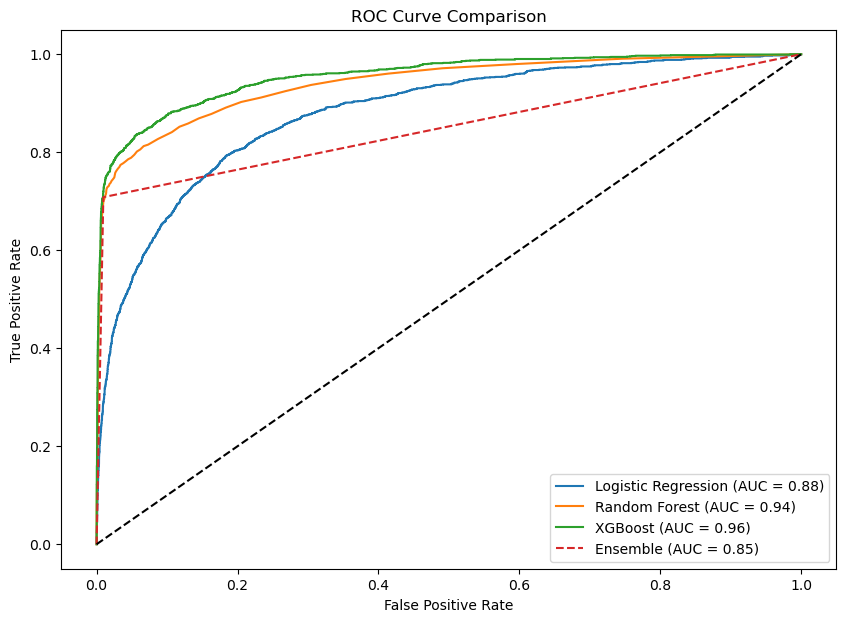

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Load the training dataset
train_data = pd.read_csv("D:\\AIT582\\Final Project\\Loan approval\\train.csv")

# Data Preprocessing
def preprocess_data(data, is_train=True):
    # Fill missing values if any (depending on the data exploration results)
    data['person_emp_length'].fillna(data['person_emp_length'].median(), inplace=True)
    
    # Encode categorical variables
    le = LabelEncoder()
    categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
    for col in categorical_cols:
        data[col] = le.fit_transform(data[col])
    
    # Separate features and target if training data
    if is_train:
        X = data.drop(['id', 'loan_status'], axis=1)
        y = data['loan_status']
        return X, y
    else:
        X = data.drop(['id'], axis=1)
        return X

# Preprocess the training data
X, y = preprocess_data(train_data, is_train=True)

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train each model and get predictions on the validation set
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

predictions = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions[model_name] = model.predict(X_val)

# Ensemble Majority Voting on Validation Set
ensemble_predictions = pd.DataFrame(predictions).mode(axis=1)[0]

# Calculate performance metrics
metrics = {}
for model_name, y_pred in predictions.items():
    metrics[model_name] = {
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1 Score': f1_score(y_val, y_pred),
        'ROC AUC': roc_auc_score(y_val, models[model_name].predict_proba(X_val)[:, 1])
    }

# Ensemble metrics
metrics['Ensemble'] = {
    'Accuracy': accuracy_score(y_val, ensemble_predictions),
    'Precision': precision_score(y_val, ensemble_predictions),
    'Recall': recall_score(y_val, ensemble_predictions),
    'F1 Score': f1_score(y_val, ensemble_predictions),
    'ROC AUC': roc_auc_score(y_val, ensemble_predictions)
}

# Convert metrics to DataFrame for visualization
metrics_df = pd.DataFrame(metrics).T

# Plot performance metrics with values shown on each bar
ax = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(10, 7), legend=True)
plt.title("Model Comparison on Validation Set")
plt.ylabel("Score")

# Adding values to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.show()

# ROC Curve
plt.figure(figsize=(10, 7))
for model_name, model in models.items():
    fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {metrics[model_name]['ROC AUC']:.2f})")

# Ensemble ROC Curve
ensemble_fpr, ensemble_tpr, _ = roc_curve(y_val, ensemble_predictions)
plt.plot(ensemble_fpr, ensemble_tpr, label=f"Ensemble (AUC = {metrics['Ensemble']['ROC AUC']:.2f})", linestyle='--')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Average
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Convert y_train and y_val to categorical for TensorFlow
y_train_tf = to_categorical(y_train, num_classes=2)
y_val_tf = to_categorical(y_val, num_classes=2)

# Train individual models (Logistic Regression, Random Forest, XGBoost)
logistic_model = models['Logistic Regression']
random_forest_model = models['Random Forest']
xgboost_model = models['XGBoost']

# Get the probability predictions from the trained models
logistic_preds_train = logistic_model.predict_proba(X_train)[:, 1]
random_forest_preds_train = random_forest_model.predict_proba(X_train)[:, 1]
xgboost_preds_train = xgboost_model.predict_proba(X_train)[:, 1]

logistic_preds_val = logistic_model.predict_proba(X_val)[:, 1]
random_forest_preds_val = random_forest_model.predict_proba(X_val)[:, 1]
xgboost_preds_val = xgboost_model.predict_proba(X_val)[:, 1]

# Stack predictions as features
ensemble_train = np.stack([logistic_preds_train, random_forest_preds_train, xgboost_preds_train], axis=1)
ensemble_val = np.stack([logistic_preds_val, random_forest_preds_val, xgboost_preds_val], axis=1)

# Build a simple TensorFlow model for ensemble
ensemble_input = Input(shape=(3,))
ensemble_output = Dense(2, activation='softmax')(ensemble_input)
ensemble_model = Model(inputs=ensemble_input, outputs=ensemble_output)

# Compile the model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ensemble model
ensemble_model.fit(ensemble_train, y_train_tf, validation_data=(ensemble_val, y_val_tf), epochs=10, batch_size=32)

# Evaluate the ensemble model
loss, accuracy = ensemble_model.evaluate(ensemble_val, y_val_tf)
print(f"Ensemble model accuracy: {accuracy:.2f}")


Epoch 1/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8854 - loss: 0.5300 - val_accuracy: 0.9529 - val_loss: 0.2296
Epoch 2/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9713 - loss: 0.1535 - val_accuracy: 0.9529 - val_loss: 0.1671
Epoch 3/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9769 - loss: 0.0808 - val_accuracy: 0.9529 - val_loss: 0.1606
Epoch 4/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9833 - loss: 0.0502 - val_accuracy: 0.9525 - val_loss: 0.1664
Epoch 5/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9897 - loss: 0.0345 - val_accuracy: 0.9523 - val_loss: 0.1750
Epoch 6/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9950 - loss: 0.0245 - val_accuracy: 0.9522 - val_loss: 0.1839
Epoch 7/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9970 - loss: 0.0178 - val_accuracy: 0.9520 - val_loss: 0.1937
Epoch 8/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9982 - loss: 0.0131 - 

In [6]:
# Save the model in .keras format
ensemble_keras_path = "D:/AIT582/Final Project/ensemble_model.keras"
ensemble_model.save(ensemble_keras_path)
print(f"Ensemble model saved at {ensemble_keras_path}")

# Save the model in .h5 format
ensemble_h5_path = "D:/AIT582/Final Project/ensemble_model.h5"
ensemble_model.save(ensemble_h5_path)
print(f"Ensemble model saved at {ensemble_h5_path}")


Ensemble model saved at D:/AIT582/Final Project/ensemble_model.keras
Ensemble model saved at D:/AIT582/Final Project/ensemble_model.h5


In [4]:
import joblib

# Save the Logistic Regression model
logistic_model_path = "logistic_model.pkl"
joblib.dump(logistic_model, logistic_model_path)
print(f"Logistic Regression model saved at {logistic_model_path}")

# Save the Random Forest model
random_forest_model_path = "random_forest_model.pkl"
joblib.dump(random_forest_model, random_forest_model_path)
print(f"Random Forest model saved at {random_forest_model_path}")

# Save the XGBoost model
xgboost_model_path = "xgboost_model.pkl"
joblib.dump(xgboost_model, xgboost_model_path)
print(f"XGBoost model saved at {xgboost_model_path}")

# Save the scaler
scaler_path = "scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved at {scaler_path}")


Logistic Regression model saved at logistic_model.pkl
Random Forest model saved at random_forest_model.pkl
XGBoost model saved at xgboost_model.pkl
Scaler saved at scaler.pkl
